# Imports

important notes \n
1-USE JUPYTER NOT JUPYTERLAB
2-to enable tf 2.0
you can go to the Conda tab (on Jupyter and not JupyterLab) and select the tensorflow_p36 environment. On the bottom left, you can search "tensorflow" in the available Conda packages. There will be a TF2.0 option. Check that box, and the click on the right arrow, which will install TF2.0 into your tensorflow_p36 environment.
3- use the conda_tensorflow_p36 kernel
Restart any existing notebooks that are open.

Note: This works only with Jupyter and not JupyterLab.
3-use tf 2.0.0

In [ ]:
!pip install --upgrade pip         # pip 19.0 or higher is required for TF 2
!pip install --upgrade setuptools  # Otherwise you'll get annoying warnings about bad installs
!pip install --user --upgrade tensorflow==2.0.0

In [1]:

import tensorflow as tf
import tensorflow.keras.backend as K
#CNN Layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Dropout,Input,BatchNormalization,GlobalAveragePooling2D,concatenate
#Activations
from tensorflow.keras.layers import ReLU,LeakyReLU
from tensorflow.keras.activations import tanh,sigmoid
#save and load
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from PIL import Image
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from datetime import datetime
import cv2
import numpy as np
import glob
import os
import urllib

# !!! DONT USE CV2 IMAGE FUNCTIONS AT ALL USE IMAGE LIBRARY AND PLT.IMSHOW

In [2]:
#Check version to be 2.0.0 exactly
tf.__version__

'1.15.2'

# Setting Random Seed and Gpu Configuration

In [3]:
# """
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = .23
# """
# RandSeed = np.random.randint(0,1000)
# np.random.seed(RandSeed)
# tf.random.set_seed(RandSeed)

# Path Variables and Global Variables

In [4]:
PathDataset = 'kaggle/'  #change dir to your project folder
# PathDatasetFood="kaggle/gantraintest/food"
PathTrainColorImagesOriginal="images/"
PathTrainColorImagesResized="train_rgb_resized/"
PathTrainGrayImagesResied="train_gray_resized/"

#PathTestColorImagesOriginal="test/test/"
#PathTestGrayImagesResied="test_gray_resized/"

PathProgressImages="ProgessCheckImages/"

# PathGeneratorCheckPoints="GeneratorCheckpoints/"
# PathDiscCheckPoints="DiscriminatorCheckpoints/"
# PathGanCheckPoints="GanCheckpoints/"

PathGeneratorAll="GeneratorModelAll/"
PathDiscAll="DiscriminatorModelAll/"
PathGanAll="GanModelAll/"

PathGeneratorWeights="GeneratorWeights/"
PathDiscriminatorWeights="DiscriminatorWeights/"
PathGanWeights="GanWeights/"

PathPerformanceFiles="Performance/"

#ONLY CURRENTLY
os.chdir(PathDataset)  #change dir


# Utility Functions Definition

In [5]:
def DownloadFile(url):
    '''
    Downloads the file of a given url
    '''
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

      

In [6]:
def DisplayImages(Images,NumColumns=2,SubPlot=False,SubPlotSize=False):
    #Denormalize Images from -1,1 to 0,255 to be displayed correctly
    Images = (np.array(Images,dtype='float32')*127.5)+127.5
    Images = np.array(Images,dtype='int32')
#     print(Images)
#     plt.imshow(Images[0])
#     plt.show()
    if SubPlot and SubPlotSize:
        f, a = plt.subplots(int(len(Images)/NumColumns),NumColumns,figsize=SubPlotSize)
    else:
        f,a = plt.subplots(int(len(Images)/2),2,figsize=(20,20))
    a = a.flatten()
    i=0
    for img in Images:
#         a[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        a[i].imshow(img)

        a[i].axis('off')
        i=i+1
    #plt.subplots_adjust(left=1,right=2,bottom=0.1,top=2,wspace=.1, hspace=.1)
    #plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.axis('off')
    plt.show()
        

In [7]:
def DisplayImagesSideBySide(Images1,Images2,Images3,NumColumns=2,SubPlot=False,SubPlotSize=False):
    #Denormalize Images from -1,1 to 0,255 to be displayed correctly
    Images1 = (np.array(Images1,dtype='float32')*127.5)+127.5
    Images1 = np.array(Images1,dtype='int32')
    Images2 = (np.array(Images2,dtype='float32')*127.5)+127.5
    Images2 = np.array(Images2,dtype='int32')
    Images3 = (np.array(Images3,dtype='float32')*127.5)+127.5
    Images3 = np.array(Images3,dtype='int32')
#     print(Images)
#     plt.imshow(Images[0])
#     plt.show()
    if SubPlot and SubPlotSize:
        f, a = plt.subplots(int(len(Images1)*3/NumColumns),NumColumns,figsize=SubPlotSize)
    else:
        f,a = plt.subplots(int(len(Images1)*3/3),3,figsize=(20,20))
    a = a.flatten()
    i=0
    for img1,img2,img3 in zip(Images1,Images2,Images3):
#         a[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        a[i].imshow(img1)
        a[i].axis('off')
        i=i+1
        a[i].imshow(img2)
        a[i].axis('off')
        i=i+1
        a[i].imshow(img3)
        a[i].axis('off')
        i=i+1
    plt.subplots_adjust(left=1,right=2,bottom=0.1,top=2,wspace=.1, hspace=.1)
    #plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.axis('off')
    plt.show()

In [8]:
def GetTrainImagePaths(PathColor=PathTrainColorImagesResized,PathGray=PathTrainGrayImagesResied):
    PathColorImgs= glob.glob(PathColor+'/*.jpg')
    PathColorImgs.sort()
    PathGrayImgs= glob.glob(PathGray+'/*.jpg')
    PathGrayImgs.sort()
    return PathColorImgs,PathGrayImgs

In [9]:
# def GetTestImagePaths(PathGrayTest=PathTestGrayImagesResied,PathTestOriginal=PathTestColorImagesOriginal):
#     PathGrayImgs= glob.glob(PathGrayTest+'/*.jpg')
#     PathGrayImgs.sort()
#     PathOriginal= glob.glob(PathTestOriginal+'/*.jpg')
#     PathOriginal.sort()
#     return PathGrayImgs,PathOriginal

In [10]:
def GenerateProgessImages(ColorImgPaths,GrayImgPaths,NumProgessImages,NumTotalImages):
    indexes=np.random.randint(0,NumTotalImages-1,NumProgessImages)
  
    ProgressColorImg = []
    ProgressGrayImg = []
    
    for idx in indexes:
        ProgressColorImg.append(np.array(Image.open(ColorImgPaths[idx]).convert('RGB')))
        ProgressGrayImg.append(np.array(Image.open(GrayImgPaths[idx]).convert('RGB')))
      #  print(ColorImgPaths[idx])
       # print(GrayImgPaths[idx])
    ProgressColorImg = (np.array(ProgressColorImg,dtype='float32')-127.5)/127.5
    ProgressGrayImg = (np.array(ProgressGrayImg,dtype='float32')-127.5)/127.5
    
#     for img in ProgressColorImg:
#         plt.imshow(img)
#         cv2.imshow('',img)
    #DONT USE CV2.IMSHOW IN AWS IT CRASHES THE KERNEL
    #use plt.imshow()

    return ProgressColorImg,ProgressGrayImg



In [11]:
def GenerateRealImages(ColorImgPath,GrayImgPath,NumImages):
    indexes=np.random.randint(0,int(len(ColorImgPath))-1,NumImages)

    ColorArr= []
    GrayArr=[]

    for idx in indexes:
#         ColorArr.append(np.array(cv2.imread(ColorImgPath[idx])))
#         GrayArr.append(np.array(cv2.imread(GrayImgPath[idx])))
        ColorArr.append(np.array(Image.open(ColorImgPath[idx]).convert('RGB')))
        GrayArr.append(np.array(Image.open(GrayImgPath[idx]).convert('RGB')))

    ColorArr = (np.array(ColorArr,dtype='float32')-127.5)/127.5
    GrayArr = (np.array(GrayArr,dtype='float32')-127.5)/127.5
        
    LabelReal = np.ones(shape=(NumImages,1))
    
    return ColorArr,GrayArr,LabelReal



In [12]:
def GenerateFakeGeneratorImages(GeneratorModel,GrayImagesPath,NumImages):
    indexes=np.random.randint(0,int(len(GrayImagesPath))-1,NumImages)
    GrayArr=[]

    for idx in indexes:
        Img = np.array(Image.open(GrayImagesPath[idx]).convert('RGB'))
        GrayArr.append(Img)
        

    GrayArr = (np.array(GrayArr,dtype='float32')-127.5)/127.5
    
    GenColorArr=GeneratorModel.predict(GrayArr)
                           
    GenColorArr = np.array(GenColorArr,dtype='float32')
    LabelFake = np.zeros(shape=(NumImages,1))
    #print("!!!! gencolorarr{}".format(GenColorArr.shape))
    #print("!!!! grayarr{}".format(GrayArr.shape))
    return GenColorArr,GrayArr,LabelFake


In [13]:
#untested yet
#!!!!!!!!NOT NEEDED CAN PASS FULL ARRAY TO GENERATOR TO PREDICT EACH ELEMENT
# def GeneratorCheckProgressImages(GeneratorModel,ProgressArr,NumImages):

#     GenColorArr= []

#     for idx in indexes:
#         GenColorArr.append(np.array(ProgressArr[i]))
#     GenColorArr=np.array(GenColorArr,dtype='float32')
#     return GenColorArr
# new = Generator(ProgressColorImages)
# new.shape

In [14]:
def SavePerformance(PerformanceFilePath,EpochNumber,DiscRealLoss,DiscFakeLoss,GeneratorLoss):
    file = open(PerformanceFilePath+'Performance.txt', "a")
    file.write("\nEpoch Number {} , DiscRealLoss:{},DiscFakeLoss:{},GeneratorLoss:{}%".format(EpochNumber,DiscRealLoss,\
                                                                                               DiscFakeLoss,GeneratorLoss))
    file.close()


In [15]:
def SaveAndDisplayEpochResults(SavePath,Images1,Images2,Images3,EpochNumber):
    
  
#     f,a = plt.subplots(int(len(ImgArr)/2),2,figsize=(20,20))
#     a = a.flatten()
#     i=0
#     for img in ImgArr:
#         a[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         a[i].axis('off')
#         i=i+1
#     plt.subplots_adjust(wspace=.1, hspace=.1)
#     plt.axis('off')
#     f.savefig(SavePath+"Epoch-{}.png".format(EpochNumber))

#Denormalize Images from -1,1 to 0,255 to be displayed correctly
    Images1 = (np.array(Images1,dtype='float32')*127.5)+127.5
    Images1 = np.array(Images1,dtype='int32')
    Images2 = (np.array(Images2,dtype='float32')*127.5)+127.5
    Images2 = np.array(Images2,dtype='int32')
    Images3 = (np.array(Images3,dtype='float32')*127.5)+127.5
    Images3 = np.array(Images3,dtype='int32')
#     print(Images)
#     plt.imshow(Images[0])
#     plt.show()
    
    f,a = plt.subplots(int(len(Images1)*3/3),3,figsize=(20,20))
    a = a.flatten()
    i=0
    for img1,img2,img3 in zip(Images1,Images2,Images3):
#         a[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        a[i].imshow(img1)
        a[i].axis('off')
        i=i+1
        a[i].imshow(img2)
        a[i].axis('off')
        i=i+1
        a[i].imshow(img3)
        a[i].axis('off')
        i=i+1
    plt.subplots_adjust(left=0.1,right=1,bottom=0.1,top=1,wspace=.1, hspace=.1)
    #plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.axis('off')
    f.savefig(SavePath+"Epoch-{}.png".format(EpochNumber))
    plt.close()


In [16]:
def DisplayTestImages(Model,NumTotalImages=6000,NumProgressImages=12):
    PathGrayImgs= glob.glob(PathTestGrayImagesResied+'/*.jpg')
    PathGrayImgs.sort()

    indexes=np.random.randint(0,NumTotalImages-1,NumProgressImages)

    TestGrayImg = []

    for idx in indexes:
        TestGrayImg.append(np.array(Image.open(PathGrayImgs[idx]).convert('RGB')))
    #  print(ColorImgPaths[idx])
    # print(GrayImgPaths[idx])
    TestGrayImg = (np.array(TestGrayImg,dtype='float32')-127.5)/127.5
    #     for img in ProgressColorImg:
    #         plt.imshow(img)
    #         cv2.imshow('',img)
    #DONT USE CV2.IMSHOW IN AWS IT CRASHES THE KERNEL
    #use plt.imshow()

    DisplayImagesSideBySide(np.array(Model.predict(TestGrayImg)),TestGrayImg,TestGrayImg)

# Loss Functions Definitions

In [17]:
"""
########## VGG16 ###############
*VGG16 is a image classification network trained on imagenet 14M images belonging to 1000 classes
*it's input is 224,224,3 !THAT'S WHY K.RESIZE(224......)
*the loss is taken from the 4th layer whose output is 28*28*512

############ LOSSES #############

#### 1) Feature level loss ####


The second loss that we use is FeatureLevel loss i.e L2 distance between the activation(φj)
of the 4th layer of the 16-layer VGG network (VGG16) pre-trained on the ImageNet dataset 
to retain high-level features like specific colors to objects and shapes

### 2)Total Variation loss ####
TotalVariation loss  is such that the GAN produces similar colors
that were used for sketch-color image pairs in the training data.


### 3)pixel level loss #####

The first loss that we use is PixelLevel loss i.e L1 
distance between each pixel of target color image and generated color image as,

Custom loss for Pixel2Pixel level translation so that colors don't 
come out the edges of generated images.


***weights 
pixel level -> 100
feature loss -> 0.1
total var. -> 0.0001


"""
pixelLevelLoss_weight=100
totalVariationLoss_weight=.0001
featureLevelLoss_weight=.01

def featureLevel_loss(y, g): 
  def finalFLoss(y_true, y_pred):
    return K.mean( K.sqrt( K.sum( K.square( y - g ) ) ) )
  
  return finalFLoss

def totalVariation_loss(y, g):

  def finalTVLoss(y_true, y_pred):
    return K.abs( K.sqrt( K.sum(K.square(g[:, 1:, :, :] - g[:, :-1, :, :])) + K.sum(K.square(g[:, :, 1:, :] - g[:, :, :-1, :])) ) )
    # return K.mean( K.abs( K.sqrt( K.square(g[:, :-1, :-1, :] - g[:, 1:, :-1, :]) + K.square(g[:, :-1, :-1, :] - g[:, :-1, 1:, :]) ) ) )
  
  return finalTVLoss

def pixelLevel_loss(y, g):

  def finalPLoss(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  
  return finalPLoss


def binaryCrossEntropy(from_logits=False):
  
  def finalBCELoss(y_true, y_pred):
    return  K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
  
  return finalBCELoss

def ColorizationLoss(y,g,from_logits=False):
    def colorloss(y_true,y_pred):

        featurelevel =  K.mean( K.sqrt( K.sum( K.square( y - g ) ) ) )
        totalvar =  K.abs( K.sqrt( K.sum(K.square(g[:, 1:, :, :] - g[:, :-1, :, :])) + K.sum(K.square(g[:, :, 1:, :] - g[:, :, :-1, :])) ) )
        pixellevel = K.mean( K.abs( y - g ) )
        binarycrossentropy = K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)

        return pixelLevelLoss_weight * pixellevel + totalVariationLoss_weight* totalvar + featureLevelLoss_weight * featurelevel
    
    return colorloss
    

    

    

# lambda y_true, y_pred : tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
#                                              pixelLevelLoss_weight * pixelLevelLoss(y_true, y_pred) + \
#                                              totalVariationLoss_weight * totalVariationLoss(y_true, y_pred) + \
#                                              featureLevelLoss_weight * featureLevelLoss(y_true, y_pred),\

# def CustomLossFnc(y_true,y_pred,from_logits=False):
#     pixelLevelLoss_weight=100
#     totalVariationLoss_weight=.0001
#     featureLevelLoss_weight=.01
#     pixelLevelLoss = K.mean( K.sqrt( K.sum( K.square( y_true - y_pred ) ) ) )
#     totalVariationLoss     = K.abs( K.sqrt( K.sum(K.square(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])) + K.sum(K.square(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])) ) )
#     featureLevelLoss     = K.mean( K.abs( y_true - y_pred ) )

#     FinalLoss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
#                                              pixelLevelLoss_weight * pixelLevelLoss + \
#                                              totalVariationLoss_weight * totalVariationLoss + \
#                                              featureLevelLoss_weight * featureLevelLoss
#     return FinalLoss
            
    

# Gan Definition Functions

In [18]:
#redo
def ConvLayer(ConvIn,NumFilters,FilterSize=4,StrideLength=2,DropOutRate=False,Activation=True,BatchNormalizationON=True,Padding="same",Alpha=0.2):
    WeightsInitializer = initializers.TruncatedNormal(mean=0.0, stddev=0.02,seed=None)  
    Layer = Conv2D(NumFilters,FilterSize,StrideLength,padding=Padding,kernel_initializer=WeightsInitializer)(ConvIn)
    if BatchNormalizationON:
        Layer= BatchNormalization()(Layer)

    if Activation:
        Layer=LeakyReLU(alpha=Alpha)(Layer)


    print(Layer.shape)
    return Layer


# !!!!!!! GOOGLE PADDING SAME VS VALID 

In [19]:
#redo
def ConvTransLayer(ConvTransIn,NumFilters,FilterSize=4,StrideLength=2,DropOutRate=False,convOut=None,Activation=True,BatchNormalizationON=True,Padding="same",Alpha=0.2):
    WeightsInitializer = initializers.TruncatedNormal(mean=0.0, stddev=0.02,seed=None)   
    Layer = Conv2DTranspose(NumFilters,FilterSize,StrideLength,padding='same',kernel_initializer=WeightsInitializer)(concatenate([ConvTransIn, convOut]) if convOut is not None else ConvTransIn)

    if BatchNormalizationON:
        Layer= BatchNormalization()(Layer)
    if Activation:
        Layer=LeakyReLU(alpha=Alpha)(Layer)
    if DropOutRate:
        Layer=Dropout(rate=DropOutRate)(Layer)
    print(Layer.shape)
    return Layer


In [20]:
#redo
def CreateGenerator(DropOut,Alpha,InputShape=(512,512,3)):
  GeneratorInput = Input(InputShape)

  NumFiltersGenerator=16

  ConvLayerOut1=ConvLayer(GeneratorInput,NumFilters=NumFiltersGenerator,BatchNormalizationON=False,Alpha=Alpha)
  ConvLayerOut2=ConvLayer(ConvLayerOut1,NumFilters=NumFiltersGenerator*2,Alpha=Alpha)
  ConvLayerOut3=ConvLayer(ConvLayerOut2,NumFilters=NumFiltersGenerator*4,Alpha=Alpha)
  ConvLayerOut4=ConvLayer(ConvLayerOut3,NumFilters=NumFiltersGenerator*8,Alpha=Alpha)
  ConvLayerOut5=ConvLayer(ConvLayerOut4,NumFilters=NumFiltersGenerator*8,Alpha=Alpha)
  ConvLayerOut6=ConvLayer(ConvLayerOut5,NumFilters=NumFiltersGenerator*8,Alpha=Alpha)
  ConvLayerOut7=ConvLayer(ConvLayerOut6,NumFilters=NumFiltersGenerator*8,Alpha=Alpha)
  ConvLayerOut8=ConvLayer(ConvLayerOut7,NumFilters=NumFiltersGenerator*8,Alpha=Alpha) 


    
  ConvTransOut1=ConvTransLayer(ConvLayerOut8,NumFiltersGenerator*8,Alpha=Alpha)
  ConvTransOut2=ConvTransLayer(ConvTransOut1,NumFiltersGenerator*8,convOut=ConvLayerOut7,DropOutRate=DropOut,Alpha=Alpha)
  ConvTransOut3=ConvTransLayer(ConvTransOut2,NumFiltersGenerator*8,convOut=ConvLayerOut6,DropOutRate=DropOut,Alpha=Alpha)
  ConvTransOut4=ConvTransLayer(ConvTransOut3,NumFiltersGenerator*8,convOut=ConvLayerOut5,DropOutRate=DropOut,Alpha=Alpha)
  ConvTransOut5=ConvTransLayer(ConvTransOut4,NumFiltersGenerator*4,convOut=ConvLayerOut4,Alpha=Alpha)
  ConvTransOut6=ConvTransLayer(ConvTransOut5,NumFiltersGenerator*2,convOut=ConvLayerOut3,Alpha=Alpha)
  ConvTransOut7=ConvTransLayer(ConvTransOut6,NumFiltersGenerator,convOut=ConvLayerOut2,Alpha=Alpha)
#   ConvTransOut8=ConvTransLayer(ConvTransOut7,NumFiltersGenerator,Alpha=Alpha) #bn false #activation false
  ConvTransOut8=ConvTransLayer(ConvTransOut7,3,convOut=ConvLayerOut1,Activation=False,BatchNormalizationON=False,Alpha=Alpha) #bn false #activation false


  GenOut = tanh(ConvTransOut8)

  return Model(inputs=GeneratorInput,outputs=GenOut)


In [21]:
#redo
def CreateDiscriminator(Alpha,InputShape=(512,512,3)):
  
  NumFiltersDiscriminator=16
    
#   DiscIn=Input(InputShape)

  inp1 = Input(InputShape) # sketch input
  inp2 = Input(InputShape) # colored input

  inp = concatenate([inp1, inp2]) # 512x512x6
  ConvLayerOut1=ConvLayer(inp,NumFilters=NumFiltersDiscriminator,BatchNormalizationON=False)
  ConvLayerOut2=ConvLayer(ConvLayerOut1,NumFilters=NumFiltersDiscriminator*2)
  ConvLayerOut3=ConvLayer(ConvLayerOut2,NumFilters=NumFiltersDiscriminator*4)
  ConvLayerOut4=ConvLayer(ConvLayerOut3,NumFilters=NumFiltersDiscriminator*8)
  ConvLayerOut5=ConvLayer(ConvLayerOut4,NumFilters=NumFiltersDiscriminator*8,FilterSize=2,StrideLength=1,Padding='valid')
  ConvLayerOut6=ConvLayer(ConvLayerOut5,NumFilters=1,FilterSize=2,StrideLength=1,Padding='valid',Activation=False,BatchNormalizationON=False)
  
  ActvLayer = sigmoid(ConvLayerOut6)

  DiscOut=GlobalAveragePooling2D()(ActvLayer)
    
  Discriminator = Model(inputs=[inp1, inp2],outputs=DiscOut)
  Optimizer= Adam(lr=0.0002,beta_1=0.5)
  Discriminator.compile(loss='binary_crossentropy',optimizer=Optimizer,metrics=['accuracy'])
  return Discriminator

#same 
  #last 2 stride 1 filter size =2 and padding valid
  # no bn in first and last 
  #sigmoid actv. then pooling



In [22]:
custom = {'custom_loss2':11111}

In [23]:
custom['custom_loss2']

11111

In [24]:
K.resize_images(Input((512,512,3)), 224, 224, 'channels_last')
tf.image.resize(Input((512,512,3)), (224, 224), tf.image.ResizeMethod.NEAREST_NEIGHBOR)


<tf.Tensor 'resize_1/ResizeNearestNeighbor:0' shape=(?, 224, 224, 3) dtype=float32>

# Gan Creation

In [25]:
def CreateGan(DiscriminatorModel,GeneratorModel):

    InputShape= (512,512,3)
    
    DiscriminatorModel.trainable= True
    #Vgg Models
    vgg_net1 = Model(inputs=vgg.input, outputs=ReLU()(vgg.get_layer('block2_conv2').output))
    vgg_net2 = Model(inputs=vgg.input, outputs=ReLU()(vgg.get_layer('block2_conv2').output))
    
    pixelLevelLoss_weight=100
    totalVariationLoss_weight=.0001
    featureLevelLoss_weight=.01


    #generator
    GrayInput = Input(InputShape)
    GenOutColorImage = GeneratorModel([GrayInput])
    OriginalColorImage = Input(InputShape)
    #to train Generator  only 
#     DiscriminatorModel.trainable=False

    
    #print(concatenate([GrayInput,GenOutColorImage]))
    # ======= Discriminator ======= #
    DiscriminatorOutput = DiscriminatorModel([GrayInput,GenOutColorImage])
    OriginalColorImage = Input(InputShape)


    # =================== PixelLevel Loss =================== #
    pixelLevelLoss = pixelLevel_loss(OriginalColorImage,GenOutColorImage)

    # =================== TotalVariation Loss =================== #
    totalVariationLoss = totalVariation_loss(OriginalColorImage,GenOutColorImage)

    # =================== FeatureLevel Loss =================== # 
    # Output dimensions must be positive keras backend resize_images : https://stackoverflow.com/a/57218765/9079093

    # K.resize_images(color_inp, .4375, .4375, 'channels_last', 'bilinear')
    net1_outp = vgg_net1([tf.image.resize(OriginalColorImage, (224, 224), tf.image.ResizeMethod.BILINEAR)])

    # K.resize_images(gen_color_output, .4375, .4375, 'channels_last', 'bilinear') 
    net2_outp = vgg_net2([tf.image.resize(GenOutColorImage, (224, 224), tf.image.ResizeMethod.BILINEAR)])

    featureLevelLoss = featureLevel_loss(net1_outp,\
                                       net2_outp)

    # =================== CrossEntropy Loss =================== #
    crossEntropyLoss = binaryCrossEntropy()

    # =================== Final Model =================== #
    model = Model(inputs=[GrayInput,OriginalColorImage], outputs=DiscriminatorOutput)

    opt = Adam(lr=.0002, beta_1=.5)

    def custom_loss34(y_true,y_pred):
        return tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
                                             pixelLevelLoss_weight * pixelLevelLoss(y_true, y_pred) + \
                                             totalVariationLoss_weight * totalVariationLoss(y_true, y_pred) + \
                                             featureLevelLoss_weight * featureLevelLoss(y_true, y_pred),\

    print(custom['custom_loss2'])
    custom['custom_loss2']=custom_loss34
    print("HERERRRR")
    print(custom['custom_loss2'])
    print(custom_loss34)
    # Single output multiple loss functions in keras : https://stackoverflow.com/a/51705573/9079093
    model.compile(loss=custom_loss34,optimizer=opt,experimental_run_tf_function=False)

    return model
# # =================== Final Model =================== #
#     model = Model(inputs=[GrayInput, OriginalColorImage], outputs=DiscriminatorOutput)

#     opt = Adam(lr=.0002, beta_1=.5)

#     # Single output multiple loss functions in keras : https://stackoverflow.com/a/51705573/9079093
#     model.compile(loss=ColorizationLoss,optimizer=opt,experimental_run_tf_function=False)

#     return model

In [26]:
#     inp1 = np.random.randint(0,1000,(3,3,5)) # sketch input
#     inp2 =np.random.randint(0,1000,(3,3,5))

#     inp = concatenate([inp1, inp2]) # 512x512x6
#     print(inp1)
#     print(inp2)
#     print(inp1.shape)
#     print(inp2.shape)
#     print(inp.shape)
#     print(inp)

In [27]:
def TrainGan(GanModel,GeneratorModel,DiscriminatorModel,GrayImgPaths,ColorImagePaths,ProgressGrayImages,ProgressColorImages,NumEpochs,BatchSize,NumStartEpoch):
     
    NumBatches=int(len(GrayImgPaths)/BatchSize)
    #file = open(PathPerformanceFiles+'Performancebatchtest.txt', "a")
    
    if NumStartEpoch > NumEpochs:
        print("Please enter Start Number lower than total epochs !")
    for Epoch in range(NumStartEpoch,NumEpochs):
        for Batch in range(NumBatches):
            
            #DiscriminatorModel.trainable=True
            

            if not Batch%2:
                
                #Generate real images 
                RealColorImages,RealGrayImages,LabelReal = GenerateRealImages(ColorImagePaths,GrayImgPaths,int(BatchSize/2))
         
            #Train Discriminator on real images
                RealDiscriminitorLoss,_= DiscriminatorModel.train_on_batch([RealGrayImages,RealColorImages],LabelReal *.9)
            
            if not Batch%3:
                             #Generate fake images
                FakeColorImages,FakeRealGrayImages,LabelFake= GenerateFakeGeneratorImages(GeneratorModel,GrayImgPaths,int(BatchSize/2))
            
            #Train Discriminator on fake images
                FakeDiscriminatorLoss,_ =DiscriminatorModel.train_on_batch([FakeRealGrayImages,FakeColorImages],LabelFake)
            
#             #avoids a warning
#             DiscriminatorModel.trainable=False
            
        
            
            #Generate real images 
            RealColorImages,RealGrayImages,LabelReal = GenerateRealImages(ColorImagePaths,GrayImgPaths,int(BatchSize/2))
         
            GeneratorLoss = GanModel.train_on_batch([RealGrayImages,RealColorImages],LabelReal)
            print("Epoch #{}/{} Batch #{}/{} RealDiscLoss:{},FakeDiscLoss:{},GeneratorLoss:{}".format(Epoch+1,NumEpochs,Batch+1,NumBatches,RealDiscriminitorLoss,FakeDiscriminatorLoss,GeneratorLoss))
     #       file.write("Epoch #{}/{} Batch #{}/{} RealDiscLoss:{},FakeDiscLoss:{},GeneratorLoss:{}".format(Epoch+1,NumEpochs-NumStartEpoch,Batch+1,NumBatches,RealDiscriminitorLoss,FakeDiscriminatorLoss,GeneratorLoss))
        
        if Epoch % 3 == 0 :
            #Save Models' weights only
            SaveModelWeightsEpoch(Generator,PathGeneratorWeights,Epoch)
            SaveModelWeightsEpoch(Discriminator,PathDiscriminatorWeights,Epoch)
            SaveModelWeightsEpoch(Gan,PathGanWeights,Epoch)

            #Test ProgressImages on Generator
            ProgressGeneratorColored = GeneratorModel.predict(ProgressGrayImages)

            #Display Progress Images after each epoch
            #!!Don't enable display to speed up training just save figure and check it later
            #DisplayImagesSideBySide(np.array(ProgressGeneratorColored),ProgressColorImages,ProgressGrayImages,3,True,(20,20))
            #DisplayImages(ProgressColorImages,3,True,(20,20))



            SaveAndDisplayEpochResults(PathProgressImages,np.array(ProgressGeneratorColored),np.array(ProgressColorImages),np.array(ProgressGrayImages),Epoch)
        
        SavePerformance(PathPerformanceFiles,Epoch,RealDiscriminitorLoss,FakeDiscriminatorLoss,GeneratorLoss)

        #Clear Cell output after each epoch
       # display.clear_output(True)
    #file.close()

 

# Save and Load Model

In [28]:
def SaveModelAllEpoch(Model,FilePath,EpochNumber):
  Model.save(FilePath+"Epoch-{}".format(EpochNumber))


In [29]:
def SaveModelWeightsEpoch(Model,FilePath,EpochNumber):
  FullPath=FilePath+"Epoch-{}".format(EpochNumber)
  Model.save_weights(FullPath ,save_format='tf')



In [30]:
def LoadModelAllEpoch(FilePath,EpochNumber):
  return load_model(FilePath+"Epoch-{}".format(EpochNumber),custom_objects={'custom_loss34': custom['custom_loss2']})


In [31]:
def LoadModelWeightsEpoch(Model,FilePath,EpochNumber):
    Model.load_weights(FilePath+"Epoch-{}".format(EpochNumber))
    return Model


# Setting Test or Create Mode

In [31]:
TestMode=0
# set to 0 for create a new model
# set to 1 to load existing model

In [ ]:
!mkdir kaggle
os.chdir("kaggle")

# Dataset Downloading From URL

In [ ]:
DownloadFile("https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz")

In [ ]:
import tarfile
my_tar = tarfile.open('mpii_human_pose_v1.tar.gz')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

In [ ]:
os.chdir('images')
!ls

In [ ]:
img = np.array(cv2.imread('040659054.jpg'))
print(img.shape)
plt.imshow(img[:,:,::-1])

In [ ]:
img = cv2.imread("images/040659054.jpg")
plt.imshow(img[:,:,::-1])

# Dataset Downloading

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json  # set permission
!kaggle datasets download -d kmader/food41 -p ./kaggle/gantraintest/food
# os.chdir(PathDataset)  #change dir
# !unzip -q beginner.zip

In [ ]:
os.chdir(PathDatasetFood)  #change dir


In [ ]:
!pwd

In [ ]:
!ls

In [ ]:
!rm -R food/

In [ ]:
!unzip -q food41.zip

# Creating Folders

In [ ]:
!mkdir train_rgb_resized
!mkdir train_gray_resized
!mkdir test_gray_resized
!mkdir ProgessCheckImages
!mkdir GeneratorCheckpoints
!mkdir DiscriminatorCheckpoints
!mkdir GanCheckpoints
!mkdir GeneratorModelAll
!mkdir DiscriminatorModelAll
!mkdir GanModelAll
!mkdir GeneratorWeights
!mkdir DiscriminatorWeights
!mkdir GanWeights
!mkdir Performance

In [ ]:
!mkdir train_rgb_resized
!mkdir train_gray_resized

In [ ]:
print((glob.glob('images/*/*.jpg'))[600:1200])

# Dataset Preprocessing

In [ ]:
def TrainPreprocessing():
    i = 1
    for image in glob.glob('images/*.jpg'):
        img_path = image
        img = cv2.imread(img_path)
        print(i)
        dim = (512, 512)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        cv2.imwrite("train_rgb_resized/"+str(i)+".jpg",img)
        cv2.imwrite("train_gray_resized/"+str(i)+".jpg",gray_img)
        i+=1
    

TrainPreprocessing()

# def TestPreprocessing():
#     i = 1
#     for image in glob.glob('test/test/*.jpg'):
#         img_path = image
#         img = cv2.imread(img_path)
#         print(i,'/6000')
#         dim = (512, 512)
#         img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
#         gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         cv2.imwrite("test_gray_resized/"+str(i)+".jpg",gray_img)
#         i+=1

# TestPreprocessing()


# HyperParameters

In [32]:
alpha=.2 #leaky relu param
learning_rate=.0002
drop_rate=.5
beta_1=.5

In [33]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# !rm -R DiscriminatorWeights/*
# !rm -R GeneratorWeights/*
# !rm -R ProgessCheckImages/*
# !rm -R GanWeights/*


# Models Creation and Summaries

In [34]:
Discriminator=CreateDiscriminator(.2)
Generator=CreateGenerator(drop_rate,.2)
Gan =CreateGan(Discriminator,Generator)

# print("####Discriminitor Architecture####")
# Discriminator.summary()

# print("####Generator Architecture####")
# Generator.summary()

# print("####Gan Architecture####")
# Gan.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(?, 256, 256, 16)
(?, 128, 128, 32)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 31, 31, 128)
(?, 30, 30, 1)
(?, 256, 256, 16)
(?, 128, 128, 32)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 4, 4, 128)
(?, 2, 2, 128)
(?, 4, 4, 128)
(?, 8, 8, 128)
(?, 16, 16, 128)
(?, 32, 32, 128)
(?, 64, 64, 64)
(?, 128, 128, 32)
(?, 256, 256, 16)
(?, 512, 512, 3)
11111
HERERRRR
<function CreateGan.<locals>.custom_loss34 at 0x7ff3f87100d0>
<function CreateGan.<locals>.custom_loss34 at 0x7ff3f87100d0>


# Training

In [33]:
    # ColorImagePaths,GrayImgPaths =GetTrainImagePaths()

    # ProgressColorImages,ProgressGrayImages = GenerateProgessImages(ColorImagePaths,GrayImgPaths,12,len(GrayImgPaths))
    # print(ProgressColorImages.shape,ProgressGrayImages.shape)

In [34]:
# ColorImagePaths,GrayImgPaths =GetTrainImagePaths()
# FakeColorImages,FakeRealGrayImages,LabelFake= GenerateFakeGeneratorImages(Generator,GrayImgPaths,int(8/2))
# print(FakeColorImages.shape,FakeRealGrayImages.shape)

In [35]:
ColorImagePaths,GrayImgPaths =GetTrainImagePaths()
ProgressColorImages,ProgressGrayImages = GenerateProgessImages(ColorImagePaths,GrayImgPaths,12,len(GrayImgPaths))


In [36]:
# ColorImagePaths=ColorImagePaths[1000:2000]
# GrayImgPaths=GrayImgPaths[1000:2000]


In [41]:
DisplayTestImages(Generator)

NameError: name 'PathTestGrayImagesResied' is not defined

In [36]:
print(np.array(ColorImagePaths).shape,np.array(GrayImgPaths).shape)

(24984,) (24984,)


In [ ]:
#BGR TO RGB DONT KNOW WHY ITS BGR 
arr = np.array(Generator.predict(ProgressGrayImages))
for sub in range(len(arr)):
    x = arr[sub]
    x= x[:,:,::-1]
    arr[sub] = x

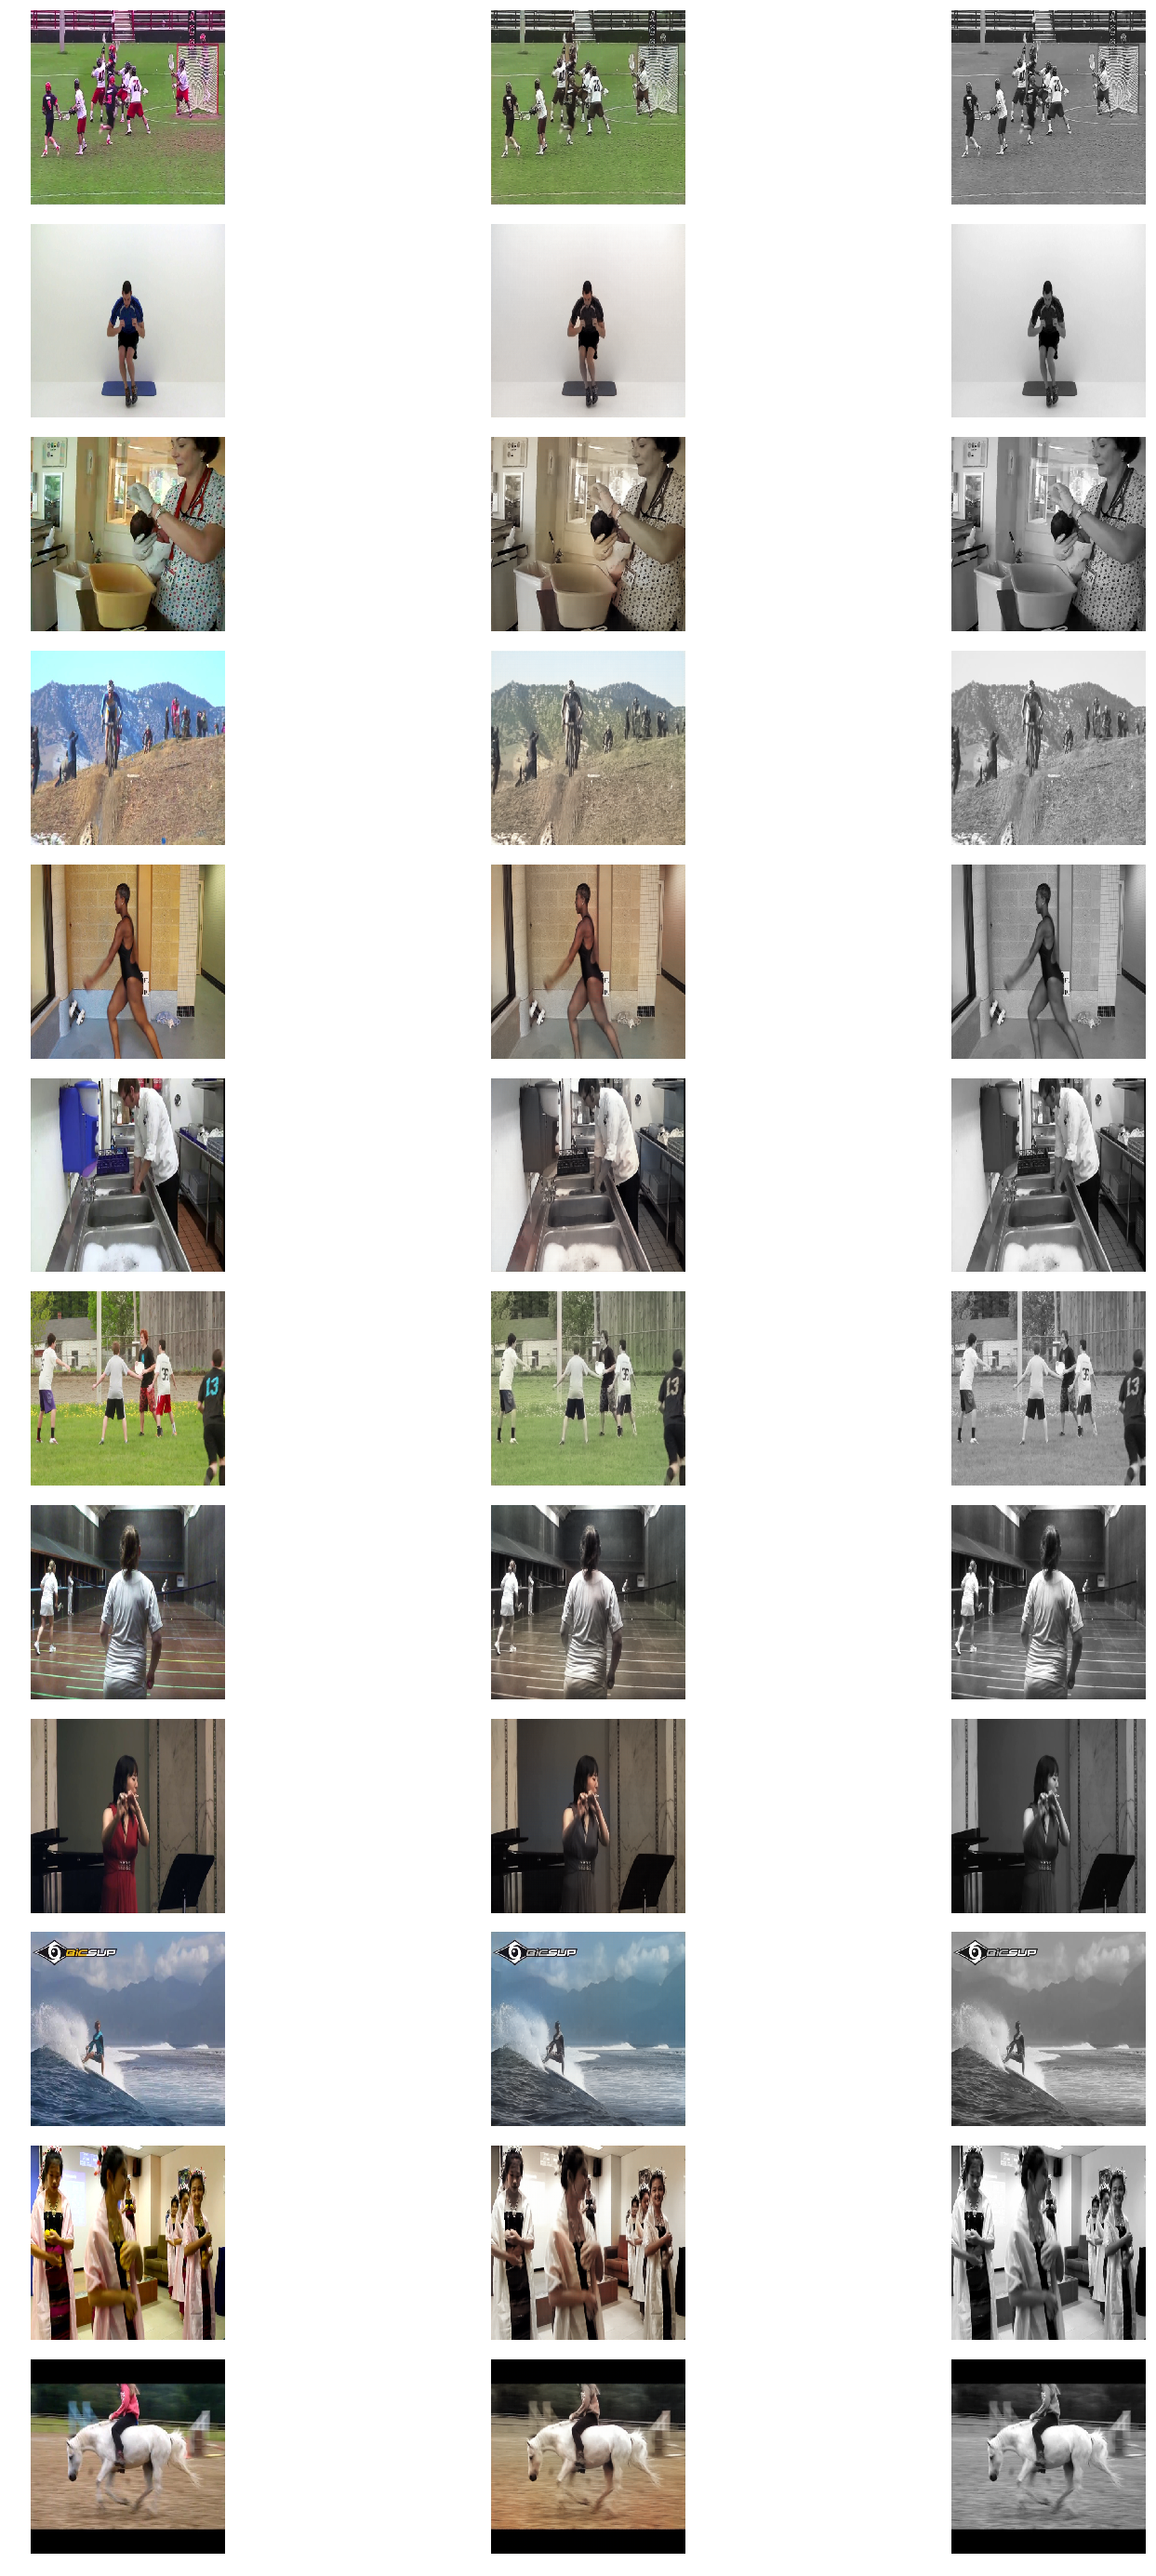

In [37]:
ProgressColorImages,ProgressGrayImages = GenerateProgessImages(ColorImagePaths,GrayImgPaths,12,len(GrayImgPaths))
DisplayImagesSideBySide(ProgressColorImages,np.array(Generator.predict(ProgressGrayImages)),ProgressGrayImages)

In [ ]:
TrainGan(Gan,Generator,Discriminator,GrayImgPaths,ColorImagePaths,ProgressGrayImages,ProgressColorImages,NumEpochs=250,BatchSize=20,NumStartEpoch=33)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Testing and Validation

In [ ]:
"""
there is no objective loss function used to train the GAN generator models and 
no way to objectively assess the progress of the traini
ng and the relative or absolute quality of the model from loss alone.

!!Therefore cannot also use earlystopping callbacks with gans
"""

In [ ]:
# concatenate([ProgressGrayImages,ProgressColorImages]).shape

In [ ]:
#test=Generator.evaluate(ProgressGrayImages,ProgressColorImages) #Can't do this  on  tf 2.2.0
Gan.evaluate([ProgressGrayImages,ProgressColorImages],[1]*12)
#before train
#341.7870178222656

In [ ]:
Gan.evaluate([ProgressGrayImages,ProgressColorImages],[1]*12)
#after train
#347.8662109375

In [ ]:
DisplayImages(np.array(test))

In [ ]:
test = Generator.predict(ProgressGrayImages)
#print(test)
DisplayImages(np.array(test[:,:,::-1]))

# Saving Model

In [ ]:
# #Save All of the Model 
# SaveModelAllEpoch(Generator,PathGeneratorAll,0)
# SaveModelAllEpoch(Discriminator,PathDiscAll,0)
# SaveModelAllEpoch(Gan,PathGanAll,0)

In [ ]:
#Save Models' weights only
SaveModelWeightsEpoch(Generator,PathGeneratorWeights,0)
SaveModelWeightsEpoch(Discriminator,PathDiscriminatorWeights,0)
SaveModelWeightsEpoch(Gan,PathGanWeights,0)

# Load Mode

In [ ]:
# #Load Model all
# Gan=LoadModelAllEpoch(PathGanAll,0)
# Discriminator=LoadModelAllEpoch(PathDiscAll,0)
# Generator=LoadModelAllEpoch(PathGeneratorAll,0)


In [36]:
#load Model Weights only
Gan=LoadModelWeightsEpoch(Gan,PathGanWeights,33)
Discriminator=LoadModelWeightsEpoch(Discriminator,PathDiscriminatorWeights,33)
Generator=LoadModelWeightsEpoch(Generator,PathGeneratorWeights,33)

# Test Images

In [ ]:
"""
changes
1- predict instead of generator()
2- image.open instead of imread
3-np.ones((#,1)) insteadof np.ones((#))
"""